# FastAI Tabular: Predicting Home Win Probability

This notebook uses FastAI's tabular module to train a neural network to predict whether the home team will win the game.

**Neural Networks** are a type of machine learning model inspired by the human brain. They consist of layers of interconnected nodes (neurons) that process data. Neural networks are particularly good at recognizing patterns in complex data, making them suitable for tasks like image recognition, natural language processing, and tabular data analysis.

**FastAI** is a high-level library built on top of PyTorch that simplifies the process of training deep learning models. It provides easy-to-use abstractions and pre-built components, allowing users to quickly build and experiment with different model architectures without needing to write extensive code.

The **tabular module** in FastAI is specifically designed for working with structured data (like spreadsheets or databases). It includes features for data preprocessing, model training, and evaluation, making it ideal for tasks involving tabular data. The tabular module can automatically handle categorical variables, missing values, and other common data issues, allowing users to focus on building and refining their models.

Together, these tools make it easier to build and train neural networks for predicting outcomes based on structured data, such as whether a football team will win the game.

## 1. Load and Prepare Data

As with the previous notebooks, we will load the training data and select some features for our model. In this instance, we have some categorical features (like team conferences) which are in contrast the the continuous features (like adjusted EPA and success rates) we have used previously. Because of this, we will split our feature set into two lists: one for categorical features and one for continuous features.

In [1]:
import pandas as pd

df = pd.read_csv("training_data.csv")
cat_features = ['week', 'home_conference', 'away_conference', 'neutral_site']
cont_features = [
    'spread',
    'home_adjusted_epa', 'home_adjusted_epa_allowed', 'away_adjusted_epa', 'away_adjusted_epa_allowed',
    'home_adjusted_success', 'home_adjusted_success_allowed', 'away_adjusted_success', 'away_adjusted_success_allowed',
    'home_talent', 'away_talent', 'home_elo', 'away_elo',
    'home_adjusted_explosiveness', 'away_adjusted_explosiveness',
    'home_adjusted_line_yards', 'away_adjusted_line_yards',
    'home_adjusted_open_field_yards', 'away_adjusted_open_field_yards',
    'home_avg_start_offense', 'away_avg_start_offense',
    'home_avg_start_defense', 'away_avg_start_defense'
]

df[cat_features + cont_features].head()

,week,home_conference,away_conference,neutral_site,spread,home_adjusted_epa,home_adjusted_epa_allowed,away_adjusted_epa,away_adjusted_epa_allowed,home_adjusted_success,...,home_adjusted_explosiveness,away_adjusted_explosiveness,home_adjusted_line_yards,away_adjusted_line_yards,home_adjusted_open_field_yards,away_adjusted_open_field_yards,home_avg_start_offense,away_avg_start_offense,home_avg_start_defense,away_avg_start_defense
0,5,ACC,ACC,True,12.0,0.149963,0.194471,0.212555,0.201952,0.416381,...,1.217263,1.205505,2.825372,2.927454,1.085852,1.257754,75.0,73.3,71.5,73.3
1,5,SEC,SEC,False,8.5,0.131300,0.178276,0.180898,0.034531,0.406290,...,1.168697,1.200406,2.825656,2.957792,1.191135,1.162176,69.6,71.9,62.9,71.7
2,5,SEC,SEC,False,2.5,0.138527,0.140860,0.142758,0.154331,0.420952,...,1.184788,1.179892,3.111430,3.034529,1.255716,1.237646,70.1,66.8,70.7,72.8
3,5,SEC,SEC,False,-32.5,0.223040,0.048181,0.188880,0.216253,0.455164,...,1.228455,1.222556,3.041990,3.059674,1.503200,1.379784,68.8,69.4,74.1,71.1
4,5,Big 12,Big 12,False,-5.5,0.157222,0.124830,0.189072,0.065593,0.469674,...,1.161835,1.166344,2.962196,3.120834,1.275008,1.324138,71.1,65.3,70.1,71.5


We will be predicting the probability of the home team winning the game, so our target variable will be binary: 1 if the home team wins, 0 if they do not.

In [2]:
df['home_win'] = (df['home_points'] > df['away_points']).astype(int)
df['home_win'].value_counts()

home_win
1    2573
0    1947
Name: count, dtype: int64

## 2. Train/Test Split

**RandomSplitter** is a function from FastAI that helps divide your dataset into two parts: one for training the model and one for testing (or validating) how well the model works. It does this by randomly picking a percentage of the data to be used for validation, while the rest is used for training.

We use RandomSplitter instead of scikit-learn's `train_test_split` because FastAI expects the split to be given as lists of row indices, not as separate DataFrames. RandomSplitter returns these indices directly, making it easier to use with FastAI's data loaders. This keeps our workflow simple and compatible with FastAI's tools.

In [3]:
from fastai.tabular.all import *

splitter = RandomSplitter(valid_pct=0.2, seed=77)
train_idx, valid_idx = splitter(df)

## 3. Create FastAI DataLoaders

Fastai DataLoaders are a key component in the fastai library, designed to efficiently load and preprocess data for training machine learning models. In the context of the tabular module, DataLoaders help manage tabular data (like CSV files) by automatically handling tasks such as splitting the data into training and validation sets, shuffling the data, and applying any necessary transformations.

When creating a DataLoader for tabular data, we often use the following transformations in the constructor:

1. **Categorify**: This transformation is used to convert categorical variables (like strings or labels) into a format that can be easily processed by machine learning algorithms. It assigns a unique integer to each category, allowing the model to understand and work with these variables.

2. **FillMissing**: This transformation addresses missing values in the dataset. Many machine learning algorithms cannot handle missing data, so this transformation fills in any gaps with a specified value (like the mean or median of the column) to ensure the dataset is complete.

3. **Normalize**: This transformation scales numerical features to a standard range, typically between 0 and 1. Normalization helps improve the convergence of the training process and can lead to better model performance.

The `bs` parameter (batch size) determines how many samples are processed together in each training iteration. A larger batch size can speed up training but requires more memory, while a smaller batch size may lead to more stable updates but can slow down the training process.

In [4]:
from fastai.tabular.all import *

# Combine train and valid into one DataFrame
dls = TabularDataLoaders.from_df(
    df,
    procs=[Categorify, FillMissing, Normalize],
    cat_names=cat_features,
    cont_names=cont_features,
    y_names='home_win',
    valid_idx=valid_idx,\
    bs=64
)

## 4. Train Neural Network Model

The `tabular_learner` function creates a neural network model designed to work with tabular (spreadsheet-like) data. It uses the DataLoaders (`dls`) we created earlier, which organize and preprocess the data for training and validation. The DataLoaders handle tasks like converting categories to numbers, filling in missing values, and normalizing the data so the model can learn effectively.

When we set `metrics=[accuracy, RocAucBinary(), F1Score()]`, we tell FastAI to track three ways of measuring how well our model is doing:

- **Accuracy**: This measures the percentage of predictions the model gets right. For example, if the model predicts correctly 80 out of 100 times, the accuracy is 80%.
- **RocAucBinary()**: This stands for "Receiver Operating Characteristic Area Under Curve" for binary classification. It shows how well the model can separate the two classes (home team wins or not) across all possible thresholds. A higher value means better separation.
- **F1Score()**: This combines precision (how many predicted wins were actually wins) and recall (how many actual wins were found by the model) into a single score. It's useful when the classes are imbalanced.

**`lr_find()`**: This function helps us find a good learning rate for training the model. The learning rate is a crucial hyperparameter that determines how much to change the model in response to the estimated error each time the model weights are updated. If the learning rate is too high, the model might converge too quickly to a suboptimal solution, while a learning rate that's too low can make the training process unnecessarily slow.

The `lr_find()` function works by training the model for a few iterations while gradually increasing the learning rate. It then plots the loss (how well the model is doing) against the learning rate. By examining this plot, we can identify a learning rate that is likely to work well for training the model.

/home/bluescar/jupyter/venv/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **

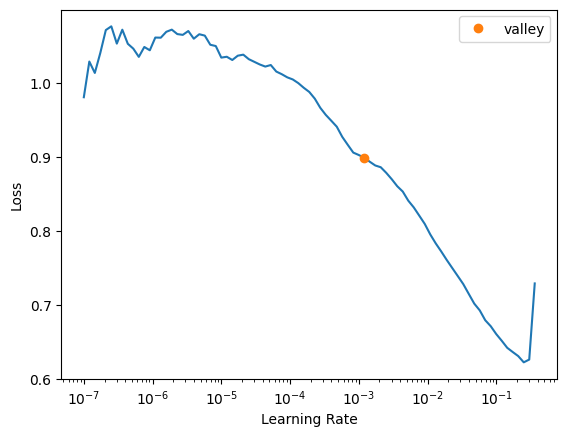

In [5]:
learn = tabular_learner(dls, metrics=[accuracy, RocAucBinary(), F1Score()])

suggested = learn.lr_find()  # Run once to find a good LR

The below code trains the neural network model for 4 rounds (called "epochs") using the data. During each epoch, the model looks at all the training examples and tries to improve its predictions. The `one_cycle` part means the learning rate (how much the model changes each time) starts low, gets higher, then goes back down, which helps the model learn better and faster. The `lr_max=suggested.valley` sets the highest learning rate to the value that was recommended earlier, so the model doesn't learn too quickly or too slowly. This process helps the model get better at predicting whether the home team will win.

In [6]:
learn.fit_one_cycle(4, lr_max=suggested.valley)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,time
0,0.575755,0.402108,0.413717,0.500000,0.000000,00:00
1,0.352206,0.266081,0.413717,0.500000,0.000000,00:00
2,0.229896,0.217401,0.413717,0.500000,0.000000,00:00
3,0.190760,0.214887,0.413717,0.500000,0.000000,00:00


## 5. Evaluate Predictions

We will now evaluate the model's predictions on the validation set. This involves checking how well the model predicts whether the home team will win the game.

1. **`get_preds()`**: This function gets the model’s predictions and the actual answers for the validation set. The predictions are probabilities that the home team will win.

2. **`squeeze()`**: This just flattens the predictions so they’re easier to work with.

3. **Thresholding**: By checking if each prediction is greater than 0.5, we turn the probabilities into simple yes/no answers (1 if the model thinks the home team will win, 0 if not).

4. **Evaluation Metrics**:
   - **Accuracy**: Shows how often the model correctly predicts whether the home team wins.
   - **AUC**: Tells us how well the model separates games where the home team wins from those where they don’t, using the predicted probabilities.
   - **F1 Score**: Balances how many times the model finds actual wins and how many of its win predictions are correct.

In this context, higher values for these metrics mean the model is better at predicting which games the home team will win. Lower values mean the predictions are less reliable.

In [7]:
preds, targs = learn.get_preds()
pred_labels = preds.squeeze() > 0.5

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

print("Accuracy:", accuracy_score(targs, pred_labels))
print("AUC:", roc_auc_score(targs, preds.squeeze()))
print("F1 Score:", f1_score(targs, pred_labels))

Accuracy: 0.665929203539823
AUC: 0.7371052366057916
F1 Score: 0.6967871485943775


## 6. Calibration Curve

As we did with the previous notebook, we will plot a calibration curve to see how well the predicted probabilities match the actual outcomes. This helps us understand if the model's confidence in its predictions is well-calibrated. The diagonal line represents perfect calibration, where predicted probabilities match actual outcomes perfectly. Points above the line indicate overconfidence (predicted probabilities are too high), while points below the line indicate underconfidence (predicted probabilities are too low). Ideally, we want our points to be close to the diagonal line.

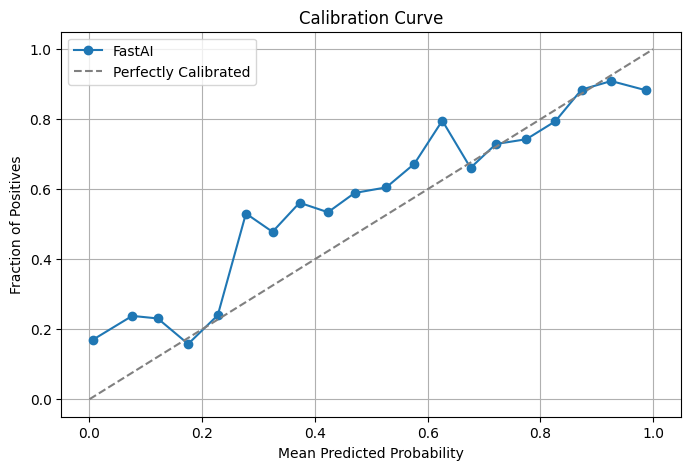

In [8]:
from sklearn.calibration import calibration_curve

# Clip predicted probabilities to [0, 1] to avoid ValueError
pred_probs = preds.squeeze().clip(0, 1)
prob_true, prob_pred = calibration_curve(targs, pred_probs, n_bins=20)

plt.figure(figsize=(8, 5))
plt.plot(prob_pred, prob_true, marker='o', label='FastAI')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve")
plt.legend()
plt.grid(True)
plt.show()

## 7. Save Model

Unlike previous notebooks, we do not need to import another library to save the model. FastAI provides a built-in method to save the trained model directly. This method saves the model's architecture and learned parameters, allowing us to load it later for making predictions without needing to retrain it.

In [9]:
learn.export('fastai_home_win_model.pkl')

# Load the model later using:
# from fastai.tabular.all import load_learner
# learn = load_learner('fastai_home_win_model.pkl')

## 8. Load Model and Make Predictions
To use the saved model for predictions, load it and create a new DataFrame with the same features as the training data. The model will then give you the probability that the home team will win, as a number between 0 and 1.

In [24]:
model = load_learner('fastai_home_win_model.pkl')

cat_features = ['week', 'home_conference', 'away_conference', 'neutral_site']
cont_features = [
    'spread',
    'home_adjusted_epa', 'home_adjusted_epa_allowed', 'away_adjusted_epa', 'away_adjusted_epa_allowed',
    'home_adjusted_success', 'home_adjusted_success_allowed', 'away_adjusted_success', 'away_adjusted_success_allowed',
    'home_talent', 'away_talent', 'home_elo', 'away_elo',
    'home_adjusted_explosiveness', 'away_adjusted_explosiveness',
    'home_adjusted_line_yards', 'away_adjusted_line_yards',
    'home_adjusted_open_field_yards', 'away_adjusted_open_field_yards',
    'home_avg_start_offense', 'away_avg_start_offense',
    'home_avg_start_defense', 'away_avg_start_defense'
]

df = pd.read_csv("training_data.csv").query("season == 2023 and week == 8").reset_index(drop=True)

df[cat_features + cont_features].head()

dls = model.dls.test_dl(df[cat_features + cont_features])

df['predicted'] = model.get_preds(dl=dls)[0].numpy().squeeze().clip(0, 1)

df[['home_team', 'away_team', 'spread', 'predicted']].head(10)

,home_team,away_team,spread,predicted
0,Alabama,Tennessee,-8.5,1.000000
1,Missouri,South Carolina,-7.0,0.606170
2,West Virginia,Oklahoma State,-3.0,0.547662
3,Cincinnati,Baylor,-2.5,0.534694
4,BYU,Texas Tech,3.0,0.370723
5,Kansas State,TCU,-5.5,0.817639
6,Bowling Green,Akron,-7.0,0.308317
7,Miami (OH),Toledo,2.5,0.495939
8,UConn,South Florida,-1.0,0.344337
9,UAB,Memphis,7.5,0.051369


## 9. Next Steps

- **Hyperparameter Tuning:** Adjust the setting of the FastAI model to improve performance. Some important tuning parameters are:
    - **learning_rate:** The step size at each iteration while moving toward a minimum of the loss function.
    - **batch_size:** The number of training examples utilized in one iteration.
    - **layers:** The depth of the model, which can impact its ability to learn complex patterns.
    - **ps:** The dropout rate, which helps prevent overfitting by randomly setting a fraction of the input units to 0 during training.
- **Feature Engineering:** Experiment with the features included in the training data. Add new features from the data and try different combinations to see if they improve the model's performance.
- **Predict Final Margin:** Use the trained model to predict the final margin of victory for the home team. This can be done by adjusting the output layer of the model to predict a continuous value instead of a binary outcome.